# Guide to use Markov libraries

In [1]:
# import whatever libraries I want
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import msm_scripts as ms
import test_system_generator as tsg

# this stuff is import for my comparison of probability distributions later on
from dit.divergences import jensen_shannon_divergence
import dit

## Declare simulation object and generate trajectories

I want to have the option for either a small user-defined chain or a large chain that describes a given potential. In this instance I am creating a simulation object and generating a random dataset from that object.

In [ ]:
# generate a dataset from the above defined simulation object
simulation_data= [ ]
for i in range(20):
    # define a simulation object in a given potential with a particular biasing force
    sim=tsg.simulation(potential='double_well',sim_length=20000,biasing_protocol=[0,1],num_of_states=100,T=300)
    simulation_data.append(sim.generate_data())

Next we can plot the simulation trajectory we just generated as well as looking at the histogram counts of how often each state is visited.

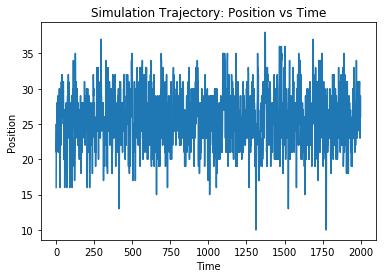

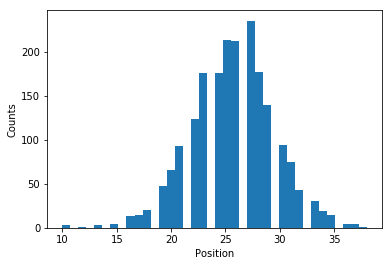

In [3]:
simulation_data[0].plot_data() # plot of trajectory
simulation_data[0].hist_data() # plot of trajectory

# Build MSM from data

I construct a Markov model object using my simulation and data set objects.

In [4]:
M=ms.discrete_markov_model(simulation_data,sim,lag_time=1)

(Created a Markov model object at lag time 1 consisting of 20 trajctories)


Now that I have my Markov model object, I can compute the free energy profile from the Markov chain.

In [5]:
G, peq = ms.free_energy_profile(M.MSM, M.temp)

LinAlgError: Array must not contain infs or NaNs

## JS divergence between our estimate $P_{eq}$ and the true $P$

In [ ]:
y=sim.y-min(sim.y)
p_true=np.exp(-y/( 0.001987 * sim.temp))
p_true = p_true/sum(p_true)

In [ ]:
X = dit.ScalarDistribution(peq)
Y = dit.ScalarDistribution(p_true)
error=jensen_shannon_divergence([X,Y])
print(np.sqrt(error))

In [ ]:
plt.plot(p_true)
plt.plot(peq)

# First study: Compare convergence for different potential energies

In this section, want to compare the rate of convergence for different shaped potential energies. The questions remains however as to what is a good method of comparison. There are clear methods for comparing two similar distributions. But then can this resulting error be compared to the similarity for a different shaped distribution. In this case, maybe RMSD difference is prefereable.

In [ ]:
barrier_types = ['flat','single_well','double_well','triple_well']
simulation_lengths = [1000, 2000, 3000, 4000, 5000, 6000, 7000]
num_of_sims = 5
replicas = 100
list_b = []
for b in barrier_types:
    list_s= []
    for s in simulation_lengths:
        list_r = []
        for r in range(replicas):

            
            sim=tsg.simulation(potential=b,sim_length=s,biasing_protocol=[0,1],num_of_states=100,T=300)
            simulation_data= [ ]
            
            for i in range(num_of_sims):
                simulation_data.append(sim.generate_data())
            
            M = ms.discrete_markov_model(simulation_data,sim,lag_time=1)
            try:
                G, peq = ms.free_energy_profile(M.MSM, M.temp)
                p_true = p_true/sum(p_true)
                X = dit.ScalarDistribution(peq)
                Y = dit.ScalarDistribution(p_true)
                error = np.sqrt(jensen_shannon_divergence([X,Y]))
            except:
                error = 10
            list_r.append(error)
        list_s.append(list_r)
    list_b.append(list_s)

Next we do a plot of the decrease in the mean error with increasing simulation length.

In [ ]:
a=np.mean(list_b,2)
for count,vec in enumerate(a):
    plt.plot(simulation_lengths,vec,label=barrier_types[count])
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Total simulation time')
    plt.ylabel('Mean error on profile')
    plt.title('Convergence of free energy profile')

# Second study: Compare convergence for umbrella sampling forces

Now I want for each potential to see what affect doing a biased simulation will have.

In [45]:
barrier_types = ['double_well']
bias_force = [25]
simulation_lengths = [2000]
num_of_sims = 50
bias_pos = np.ceil(np.linspace(1,100,(num_of_sims+2))[1:-1])
bias_pos = [int(x) for x in bias_pos]
replicas = 1

list_barrier=[]
for b in barrier_types:
    list_b = []
    for bias in bias_force:
        list_s= []
        for s in simulation_lengths:
            list_r = []
            for r in range(replicas):
                simulation_data= [ ]
                for i in range(num_of_sims):
                    sim=tsg.simulation(potential=b,sim_length=s,biasing_protocol=[bias,bias_pos[i]],num_of_states=100,T=300)
                    simulation_data.append(sim.generate_data())
            
                M = ms.discrete_markov_model(simulation_data,sim,lag_time=1)
                try:
                    G, peq = ms.free_energy_profile(M.MSM, M.temp)
                    y=sim.y-min(sim.y)
                    p_true=np.exp(-y/( 0.001987 * sim.temp))
                    p_true = p_true/sum(p_true)
                    X = dit.ScalarDistribution(peq)
                    Y = dit.ScalarDistribution(p_true)
                    error = np.sqrt(jensen_shannon_divergence([X,Y]))
                except:
                    error = 10
                list_r.append(error)
            list_s.append(list_r)
        list_b.append(list_s)
    list_barrier.append(list_b)

(Created a Markov model object at lag time 1 consisting of 50 trajctories)


(Created a Markov model object at lag time 10 consisting of 50 trajctories)


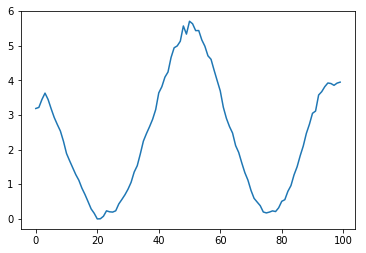

In [46]:
#for i in range(num_of_sims):
#plt.hist(simulation_data[i].data)
M = ms.discrete_markov_model(simulation_data,sim,lag_time=10)
G, peq = ms.free_energy_profile(M.MSM, M.temp)
plt.plot(G)

In [42]:
simulation_data[0].data

[1.7453292519943293,
 -2.3165279162833827,
 -2.2530613980290433,
 -2.7607935440637577,
 -2.697327025809418,
 -2.8242600623180967,
 -2.697327025809418,
 -2.697327025809418,
 -2.443460952792061,
 -2.7607935440637577,
 -2.8242600623180967,
 -2.633860507555079,
 -2.951193098826775,
 -3.0781261353354537,
 -3.0781261353354537,
 -3.0146596170811146,
 -2.697327025809418,
 -2.633860507555079,
 -2.5703939893007397,
 -2.887726580572436,
 -2.7607935440637577,
 -2.5703939893007397,
 -3.0781261353354537,
 -2.7607935440637577,
 -2.8242600623180967,
 -2.8242600623180967,
 -2.697327025809418,
 -2.8242600623180967,
 -2.7607935440637577,
 -2.633860507555079,
 -2.697327025809418,
 -2.7607935440637577,
 -2.443460952792061,
 -2.2530613980290433,
 -2.633860507555079,
 -2.5069274710464007,
 -2.8242600623180967,
 -2.7607935440637577,
 -2.5703939893007397,
 -2.5069274710464007,
 -2.8242600623180967,
 -2.5703939893007397,
 -2.7607935440637577,
 -2.7607935440637577,
 -2.951193098826775,
 -2.8242600623180967,
 -3.

In [47]:
x=sim.x

for count, item in enumerate(simulation_data):
    item.data = [x[int(i-1)] for i in item.data]
    with open('data_'+str(count)+ '.txt', 'w') as f:
        for item1 in item.data:
            item2 = item1 
            f.write("%s\n" % item2)
            
with open('data_biaspos.txt', 'w') as f:
    for item1 in bias_pos:
        item2 = item1 
        f.write("%s\n" % item2)

with open('data_biasforce.txt', 'w') as f:
    for item1 in bias_pos:
        item2 = bias_force[0]
        f.write("%s\n" % item2)

In [ ]:
num_of_states=100

In [ ]:
list_barrier

In [ ]:
a=np.mean(list_barrier,3)
for i in range(np.shape(a)[0]):
    plt.figure()
    for j in range(np.shape(a)[1]):
        plt.plot(simulation_lengths,a[i][j],label=bias_force[j])
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Total simulation time')
    plt.ylabel('Mean error on profile')
    plt.title('Convergence of free energy profile')


# Third study: machine learning approaches for choosing the bias

I now want to try to use a machine learning approach to try and identify

In [ ]:
bias = 4
simulation_lengths = [200, 500, 1000, 2000, 3000]
num_of_sims = 40
switching_rate = 10
bias_pos = np.ceil(np.linspace(1,100,(num_of_sims+2))[1:-1])
bias_pos = [int(x) for x in bias_pos]
replicas = 100

for s in simulation_lengths:
    list_r = []
    for r in range(replicas):
        simulation_data= [ ]
        for j in range(s/switching_rate):
            for i in range(num_of_sims):
                sim=tsg.simulation(potential='double_well',sim_length=switching_rate,biasing_protocol=[bias,bias_pos[i]],num_of_states=100,T=300)
                simulation_data.append(sim.generate_data())
                M = ms.discrete_markov_model(simulation_data,sim,lag_time=1)
                # here is some stuff which will take the simulation data and biasing info and then output biasing
        try:
            G, peq = ms.free_energy_profile(M.MSM, M.temp)
            y=sim.y-min(sim.y)
            p_true=np.exp(-y/( 0.001987 * sim.temp))
            p_true = p_true/sum(p_true)
            X = dit.ScalarDistribution(peq)
            Y = dit.ScalarDistribution(p_true)
            error = np.sqrt(jensen_shannon_divergence([X,Y]))
        except:
            error = 10
        list_r.append(error)
